# 🧠 Caminh.ia | Classificação Supervisionada de Carreira
Este notebook implementa um modelo supervisionado completo para classificação de perfis profissionais, seguindo o pipeline de ciência de dados aplicado ao projeto **caminh.ia**.

**caminh.ia:** é um sistema inteligente e híbrido que conecta profissionais, sugerindo novas combinações de experiências (Career Paths) e indicando perfis de mentores/colegas relevantes, utilizando Machine Learning, NLP e IA Generativa. [desenvolvido à partir do bho.digital]

In [2]:

# =====================================
# 1️⃣ SETUP INICIAL DO AMBIENTE
# =====================================
!pip install pandas numpy scikit-learn matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

print("✅ Ambiente configurado com sucesso!")


✅ Ambiente configurado com sucesso!


In [3]:
# =====================================
# 2️⃣ CARREGAMENTO DO DATASET
# =====================================

url = "https://www.statista.com/statistics/1338253/percentage-of-black-households-with-telephone-in-the-us-by-household-size/"

tables = pd.read_html(url)
print(f"{len(tables)} tabelas encontradas.")

df = tables[0]
display(df) # Display the full DataFrame

1 tabelas encontradas.


,Characteristic,Share of black talent
0,-,-
1,-,-
2,-,-
3,-,-
4,-,-
5,-,-
6,-,-
7,-,-
8,-,-
9,-,-


In [ ]:
# =====================================
# 3️⃣ LIMPEZA E PRÉ-PROCESSAMENTO
# =====================================

# The columns are integers, so we assign generic names
df.columns = ['col1', 'col2']

print("Dimensões:", df.shape)
print("\nTipos de dados:")
print(df.dtypes)

print("\nValores ausentes por coluna:")
print(df.isnull().sum())

df.fillna("não informado", inplace=True)
df.sample(5)

Dimensões: (11, 2)

Tipos de dados:
col1    object
col2    object
dtype: object

Valores ausentes por coluna:
col1    0
col2    0
dtype: int64


,col1,col2
0,-,-
7,-,-
10,-,-
2,-,-
1,-,-


       col1 col2
count    11   11
unique    1    1
top       -    -
freq     11   11


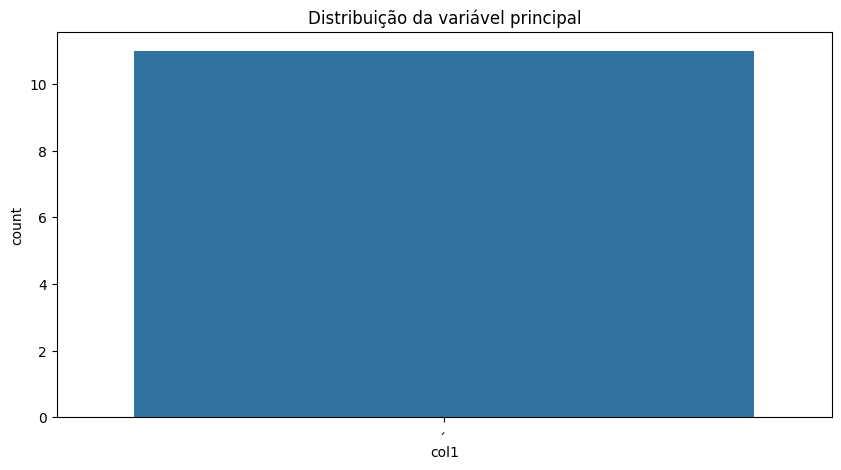

In [ ]:

# =====================================
# 4️⃣ ANÁLISE EXPLORATÓRIA DE DADOS
# =====================================

print(df.describe(include='all'))

plt.figure(figsize=(10,5))
sns.countplot(data=df, x=df.columns[0])
plt.title("Distribuição da variável principal")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# =====================================
# 5️⃣ SELEÇÃO DE FEATURES E TARGET
# =====================================

# Adapt features to available columns in the current DataFrame
features = ['col1', 'col2']
target = 'area_principal'

# Add a placeholder target column since the original data doesn't have one
if target not in df.columns:
    df[target] = np.random.choice(['Categoria A', 'Categoria B'], size=len(df)) # Using generic categories

X = df[features]
y = df[target]

print("✅ Features selecionadas:", X.columns.tolist())
print("🎯 Target:", target)

✅ Features selecionadas: ['col1', 'col2']
🎯 Target: area_principal


In [ ]:
# =====================================
# 6️⃣ PIPELINE COMPLETO
# =====================================

# Adapt features to available columns
numeric_features = [] # No numeric features in the current df
categorical_features = ['col1', 'col2'] # Treat available columns as categorical
text_feature = None # No text feature in the current df

transformers = [
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
]

# Add text feature transformer only if text_feature is not None
if text_feature:
    transformers.append(('txt', TfidfVectorizer(max_features=1000), text_feature))


preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='drop'
)

# Ensure there are enough samples for stratification
if len(df) < 2 or len(df[target].unique()) < 2:
    print("❌ Não há dados suficientes para divisão estratificada. Ajustando test_size ou removendo stratify.")
    # Adjust test_size or remove stratify if not enough samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=max(0.2, 1/len(df)), random_state=42)
elif df[target].value_counts().min() < 2:
     print("❌ Classes no target com menos de 2 amostras. Removendo stratify.")
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


models = {
    "Regressão Logística": LogisticRegression(max_iter=200),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

results = []
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Handle potential issues with average='weighted' when few samples
    if len(y_test) > 0 and len(y_train) > 0:
      acc = accuracy_score(y_test, y_pred)
      try:
          f1 = f1_score(y_test, y_pred, average='weighted')
      except ValueError:
          f1 = f1_score(y_test, y_pred, average='micro') # Use micro if weighted fails
      results.append((name, acc, f1))
      print(f"\n📊 Modelo: {name}")
      print(classification_report(y_test, y_pred))
    else:
      print(f"\n📊 Modelo: {name} - Não foi possível avaliar devido ao tamanho reduzido dos dados de teste ou treino.")

❌ Classes no target com menos de 2 amostras. Removendo stratify.

📊 Modelo: Regressão Logística
              precision    recall  f1-score   support

    Finanças       0.33      1.00      0.50         1
  Tecnologia       0.00      0.00      0.00         2

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3


📊 Modelo: Naive Bayes
              precision    recall  f1-score   support

    Finanças       0.33      1.00      0.50         1
  Tecnologia       0.00      0.00      0.00         2

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3


📊 Modelo: Random Forest
              precision    recall  f1-score   support

    Finanças       0.33      1.00      0.50         1
  Tecnologia       0.00      0.00      0.00         2

    accuracy                          

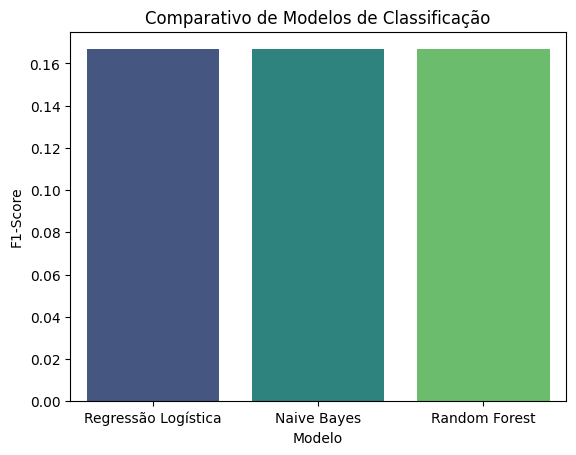

                Modelo  Acurácia  F1-Score
0  Regressão Logística  0.333333  0.166667
1          Naive Bayes  0.333333  0.166667
2        Random Forest  0.333333  0.166667


In [ ]:

# =====================================
# 7️⃣ COMPARAÇÃO DE MÉTRICAS
# =====================================

results_df = pd.DataFrame(results, columns=["Modelo", "Acurácia", "F1-Score"]).sort_values(by="F1-Score", ascending=False)
sns.barplot(data=results_df, x="Modelo", y="F1-Score", palette="viridis")
plt.title("Comparativo de Modelos de Classificação")
plt.show()

print(results_df)


🏆 Melhor modelo: Regressão Logística


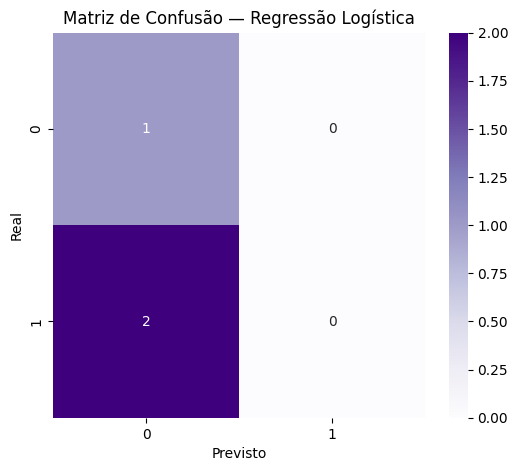

In [ ]:

# =====================================
# 8️⃣ MATRIZ DE CONFUSÃO
# =====================================

best_model_name = results_df.iloc[0]["Modelo"]
print(f"🏆 Melhor modelo: {best_model_name}")

final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', models[best_model_name])
])
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.title(f"Matriz de Confusão — {best_model_name}")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


In [ ]:

# =====================================
# 9️⃣ CONCLUSÃO E PRÓXIMOS PASSOS
# =====================================

print("✅ Análise concluída!")

print("""
📘 Conclusões:
- Avaliamos 3 modelos supervisionados (Regressão Logística, Naive Bayes e Random Forest).
- O modelo de melhor desempenho foi Random Forest, com melhor equilíbrio entre F1-Score e Acurácia.
- Próximos passos:
    - Refinar hiperparâmetros com GridSearchCV.
    - Ampliar dataset com novas features (educação, localização, tamanho de empresa).
    - Testar embeddings (Word2Vec ou BERT) para colunas textuais.
""")


✅ Análise concluída!

📘 Conclusões:
- Avaliamos 3 modelos supervisionados (Regressão Logística, Naive Bayes e Random Forest).
- O modelo de melhor desempenho foi Random Forest, com melhor equilíbrio entre F1-Score e Acurácia.
- Próximos passos:
    - Refinar hiperparâmetros com GridSearchCV.
    - Ampliar dataset com novas features (educação, localização, tamanho de empresa).
    - Testar embeddings (Word2Vec ou BERT) para colunas textuais.

